# Real-Time Script for Dst Prediction

In [1]:
# Conda dependencies are listed under environment.yml
import os
import sys
import copy
from datetime import datetime, timedelta
import getpass
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import num2date, date2num
import numpy as np
import pdb
import pickle
import requests
import scipy.io
from scipy import stats
import scipy
import warnings
from sunpy.time import parse_time
import sklearn
import pandas as pd
import matplotlib.dates as mdates
import astropy.units as u
from scipy.optimize import curve_fit, least_squares, minimize
import time
import numba
from numba import jit
from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, HeliocentricEarthEcliptic
import astrospice
#from heliocats import data as hd
from functions.data import SatData
from functions.data import PositionData
import urllib
import multiprocess as mp

import seaborn as sns
#from sklearn.metrics import mean_squared_error
#from heliocats import plot as hp

#import heliosat
#import functions as ps
from functions import data as pred
#from predstorm.config.conscnts import AU, dist_to_L1
#from predstorm.predict import dst_loss_function

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

sns.set_style('whitegrid', {'xtick.bottom': True, 'grid.color': 'gainsboro'})
sns.set_context('paper')

#data_path = '/data/aswo/data/insitu_python/'

### Update predicted arrival time at L1 using ELEvo and shock arrival at Solar Orbiter

In [2]:
print('load positions')   

data_path = '../../INGRID/data_fin/'

#positions needed for arrival time/speed calculation and plotting below
[psp, solo, sta, stereob_recon, bepi, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]=pickle.load( open( data_path+'positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p', "rb" ) )

print('done')

load positions
done


In [3]:
### Load DONKI to use DONKI-ID for updating initial parameters for ELEvo
real_time = False

if real_time:

    date=(datetime.now()-timedelta(days=5)).strftime('%Y-%m-%d')
    url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+date+'&mostAccurate=True'
    try: urllib.request.urlretrieve(url_donki,'DONKI.json')
    except urllib.error.URLError as e:
        print('DONKI not loaded')
        
else:                                                               #User defined date
    
    start_date = datetime(2024,3,23).strftime('%Y-%m-%d')
    end_date = datetime(2024,3,24).strftime('%Y-%m-%d')
    url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+start_date+'&endDate='+end_date+'&mostAccurate=True'
    try: urllib.request.urlretrieve(url_donki,'DONKI.json')
    except urllib.error.URLError as e:
        print('DONKI not loaded')
    
data_donki = pd.read_json('DONKI.json')
data_donki['time21_5'] = mdates.date2num(data_donki.time21_5)
data_donki = data_donki.groupby('associatedCMEID').mean().reset_index()

if real_time:
    print('# CMEs in last 5 days: ', len(data_donki))
    
else: 
    print('# CMEs from ', start_date, 'to', end_date,': ', len(data_donki))
print(data_donki.associatedCMEID)

# CMEs from  2024-03-23 to 2024-03-24 :  5
0    2024-03-23T01:25:00-CME-001
1    2024-03-23T01:48:00-CME-001
2    2024-03-23T02:00:00-CME-001
3    2024-03-23T08:12:00-CME-001
4    2024-03-24T03:24:00-CME-001
Name: associatedCMEID, dtype: object


In [4]:
#this you have to set:
sc_icme_start_time_solo = datetime(2024,3,23,13,30) #at Solar Orbiter from in-situ data

index = np.where(data_donki["associatedCMEID"].str.contains("2024-03-23T01:25:00-CME-001"))[0][0] #this you get from the ELEvo-output on website, october CME:2024-10-26T06:48:00 

In [5]:
#### Update initial parameter for ELEvo according to actual arrival time of CME ###

sc_measure_name = 'SolarOrbiter'

print('Sub-L1 monitor s/c: ', sc_measure_name)

distance0 = 21.5*u.solRad.to(u.km)

t0_num = data_donki.time21_5[index]
t0 = mdates.num2date(t0_num)

print('Launch time (21.5 R_Sun): ', t0)
print('Start ICME @ SolO: ', sc_icme_start_time_solo)

gamma_init = 0.1                  
ambient_wind_init = 400
speed_init = data_donki.speed[index]
x0 = [speed_init, ambient_wind_init, gamma_init]
print('Initial Parameters (DONKI): ', gamma_init, ambient_wind_init, speed_init)

kindays = 10
n_ensemble = 50000
halfwidth = np.deg2rad(35.)
#halfwidth = np.deg2rad(data_donki.halfAngle[index])
res_in_min = 10
f = 0.7

if sc_measure_name == 'PSP':
    sc_measure = psp
if sc_measure_name == 'SolarOrbiter':
    sc_measure = solo
if sc_measure_name == 'STEREO-A':
    sc_measure = sc
if sc_measure_name == 'BepiColombo':
    sc_measure = bepi
if sc_measure_name == 'Wind':
    sc_measure = wind

sc_ind_measure = np.argmin(np.abs(t0_num-sc_measure.time))
    

index_sc_heliodistance = np.argmin(np.abs(mdates.date2num(sc_icme_start_time_solo)-sc_measure.time))
cme_prop_time = (parse_time(sc_icme_start_time_solo)-parse_time(mdates.num2date(data_donki.time21_5[index]))).sec

if np.abs(np.deg2rad(data_donki.longitude[index])) + np.abs(sc_measure.lon[index_sc_heliodistance]) > np.pi and np.sign(np.deg2rad(data_donki.longitude[index])) != np.sign(sc_measure.lon[index_sc_heliodistance]): 
    delta_sc_measure = np.deg2rad(data_donki.longitude[index]) - (sc_measure.lon[index_sc_heliodistance] + 2 * np.pi * np.sign(np.deg2rad(data_donki.longitude[index])))

else:
    delta_sc_measure = np.deg2rad(data_donki.longitude[index]) - sc_measure.lon[index_sc_heliodistance]

    
def cme_r_prop(x, time_diff, distance0=distance0):
    if x[0] >= x[1]:
        accsign = 1.

    else:
        accsign = -1.

    rdrag = (accsign / (x[2] * 1e-7)) * np.log(1 + (accsign * x[2] * 1e-7) * ((x[0] - x[1]) * time_diff)) + x[1] * time_diff + distance0
    vdrag = (x[0] - x[1]) / (1 + (accsign * (x[2] * 1e-7) * (x[0] - x[1]) * time_diff)) + x[1]

    return rdrag, vdrag

rdrag, vdrag = cme_r_prop(x0, cme_prop_time)


def rmse(x, time_diff=cme_prop_time, r_sc=sc_measure.r[index_sc_heliodistance], cme_delta=delta_sc_measure): #v_sc=speed_ic, 

    if x[0] >= x[1]:
        accsign = 1.

    else:
        accsign = -1.

    r_at_sc = (accsign / (x[2] * 1e-7)) * np.log(1 + (accsign * x[2] * 1e-7) * ((x[0] - x[1]) * time_diff)) + x[1] * time_diff + distance0
    #v_at_sc= (x[2] - x[1]) / (1 + (accsign * (x[2] * 1e-7) * (x[0] - x[1]) * time_diff)) + x[1]

    cme_r_au = r_at_sc*u.km.to(u.au)

    theta_monitor = np.arctan(f**2 * np.tan(halfwidth))
    omega_monitor = np.sqrt(np.cos(theta_monitor)**2 * (f**2 - 1) + 1)   
    cme_b_monitor = cme_r_au * omega_monitor * np.sin(halfwidth) / (np.cos((halfwidth) - theta_monitor) + omega_monitor * np.sin(halfwidth))    
    cme_a_monitor = cme_b_monitor / f
    cme_c_monitor = cme_r_au - cme_b_monitor

    root = np.sin(cme_delta)**2 * f**2 * (cme_b_monitor**2 - cme_c_monitor**2) + np.cos(cme_delta)**2 * cme_b_monitor**2
    discnce_sc_monitor = (cme_c_monitor * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2 + np.cos(cme_delta)**2)

    rmse = np.sqrt((r_sc - discnce_sc_monitor)**2)

    return rmse

params_opt = minimize(rmse, x0, bounds=((0, None), (0, None), (0, None)), method='Nelder-Mead')

print('Optimization message: ', params_opt.message)

parameter = [params_opt.x[0], params_opt.x[1], params_opt.x[2]]
print('Optimized Parameters [inital CME speed, ambient wind, gamma]: ', parameter)

gamma_update = params_opt.x[2]
ambient_wind_update = params_opt.x[1]
speed_update = params_opt.x[0]

def check(x, time_diff=cme_prop_time, cme_delta=delta_sc_measure): #v_sc=speed_ic, 

    r_at_sc, v_at_sc = cme_r_prop(x, cme_prop_time)

    cme_r_au = r_at_sc*u.km.to(u.au)
    cme_v_au = v_at_sc

    theta_monitor = np.arctan(f**2 * np.tan(halfwidth))
    omega_monitor = np.sqrt(np.cos(theta_monitor)**2 * (f**2 - 1) + 1)   
    cme_b_monitor = cme_r_au * omega_monitor * np.sin(halfwidth) / (np.cos((halfwidth) - theta_monitor) + omega_monitor * np.sin(halfwidth))    
    cme_a_monitor = cme_b_monitor / f
    cme_c_monitor = cme_r_au - cme_b_monitor

    root = np.sin(cme_delta)**2 * f**2 * (cme_b_monitor**2 - cme_c_monitor**2) + np.cos(cme_delta)**2 * cme_b_monitor**2
    distance_sc_monitor = (cme_c_monitor * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2 + np.cos(cme_delta)**2)

    return distance_sc_monitor, cme_v_au, cme_r_au

check_distance, velocity_at_sc, apex_distance = check(x=parameter)
velocity = velocity_at_sc
print('Actual position of sub-L1 monitor: ', sc_measure.r[index_sc_heliodistance])
print('Calculated distance, where CME hits SolO, and apex distance using updated paramters: ', check_distance, apex_distance)
print('Velocity @SolO without update: ', vdrag)
print('Velocity @SolO with updated parameters: ', velocity_at_sc)
print(' ')


Sub-L1 monitor s/c:  SolarOrbiter
Launch time (21.5 R_Sun):  2024-03-23 03:19:00+00:00
Start ICME @ SolO:  2024-03-23 13:30:00
Initial Parameters (DONKI):  0.1 400 1613.0
Optimization message:  Optimization terminated successfully.
Optimized Parameters [inital CME speed, ambient wind, gamma]:  [1312.5235099312035, 420.06975823794846, 0.11430889434781627]
Actual position of sub-L1 monitor:  0.386600889482256
Calculated distance, where CME hits SolO, and apex distance using updated paramters:  0.3866008933792546 0.38872195706697965
Velocity @SolO without update:  1239.6289352328372
Velocity @SolO with updated parameters:  1069.6048716490363
 


In [6]:
gamma_init = [0.1, gamma_update]
ambient_wind_init = [400., ambient_wind_update]
speed_init = [data_donki.speed[index], speed_update]

def donki_kinematics(i):
    
    print('   ')
    print('Processing step ', i+1)
    
    #print(data_donki['associatedCMEID'][index])
    
    #index = data_donki.associatedCMEID[data_donki.associatedCMEID == '2024-02-27T11:36:00-CME-001'].index[0]
    distance0 = 21.5*u.solRad.to(u.km)
    t0_num = data_donki.time21_5[index]
    t0 = mdates.num2date(t0_num)

    kindays = 15
    n_ensemble = 100000
    halfwidth = np.deg2rad(35.)
    #halfwidth = np.deg2rad(data_donki.halfAngle[index])
    #print(np.rad2deg(halfwidth))
    res_in_min = 10
    f = 0.7
    kindays_in_min = int(kindays*24*60/res_in_min)

    #for sc in ['earth', 'solo']:
    
    dct = t0_num-wind.time
    wind_ind = np.argmin(np.abs(dct))
    
        
    t0_num_kindays = mdates.date2num(mdates.num2date(t0_num)+timedelta(days=kindays))
    dct0 = t0_num_kindays-wind.time
    wind_ind2 = np.argmin(np.abs(dct0))
        
    dct1 = t0_num-solo.time
    solo_ind = np.argmin(np.abs(dct1))
    
    dct2 = t0_num_kindays-solo.time
    solo_ind2 = np.argmin(np.abs(dct2))

    
    delta_wind_list = []
    for j in range(kindays_in_min):
        if np.abs(np.deg2rad(data_donki.longitude[index])) + np.abs(wind.lon[wind_ind+j:wind_ind+(j+1)]) > np.pi and np.sign(np.deg2rad(data_donki.longitude[index])) != np.sign(wind.lon[wind_ind+j:wind_ind+(j+1)]):
            delta_wind = (np.deg2rad(data_donki.longitude[index]) - (wind.lon[wind_ind+j:wind_ind+(j+1)] + 2 * np.pi * np.sign(np.deg2rad(data_donki.longitude[index]))))[0]

        else:
            delta_wind = (np.deg2rad(data_donki.longitude[index]) - wind.lon[wind_ind+j:wind_ind+(j+1)])[0]
        
        delta_wind_list.append(delta_wind)
    
    
    delta_solo_list = []
    for j in range(kindays_in_min):
        if np.abs(np.deg2rad(data_donki.longitude[index])) + np.abs(solo.lon[solo_ind+j:solo_ind+(j+1)]) > np.pi and np.sign(np.deg2rad(data_donki.longitude[index])) != np.sign(solo.lon[solo_ind+j:solo_ind+(j+1)]):
            delta_solo = (np.deg2rad(data_donki.longitude[index]) - (solo.lon[solo_ind+j:solo_ind+(j+1)] + 2 * np.pi * np.sign(np.deg2rad(data_donki.longitude[index]))))[0]

        else:
            delta_solo = (np.deg2rad(data_donki.longitude[index]) - solo.lon[solo_ind+j:solo_ind+(j+1)])[0]
            
        delta_solo_list.append(delta_solo)
    
    #times for each event kinematic
    time1=[]
    tstart1=copy.deepcopy(t0)
    tend1=tstart1+timedelta(days=kindays)
    #make 30 min datetimes
    while tstart1 < tend1:

        time1.append(tstart1)  
        tstart1 += timedelta(minutes=res_in_min)    

    #make kinematics
    
    timestep=np.zeros([kindays_in_min,n_ensemble])
    cme_r=np.zeros([kindays_in_min, 3])
    cme_v=np.zeros([kindays_in_min, 3])
    cme_lon=np.ones(kindays_in_min)*data_donki.longitude[index]
    cme_lat=np.ones(kindays_in_min)*data_donki.latitude[index]
    cme_id=np.chararray(kindays_in_min, itemsize=27)
    cme_id[:]=data_donki.associatedCMEID[index]
    cme_r_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_v_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_delta = [[x] * 3 for x in delta_wind_list]
    cme_delta_solo = [[x] * 3 for x in delta_solo_list]
    cme_hit=np.zeros(kindays_in_min)
    cme_hit[np.abs(delta_wind_list[0])<halfwidth] = 1
    cme_hit_solo=np.zeros(kindays_in_min)
    cme_hit_solo[np.abs(delta_solo_list[0])<halfwidth] = 1
    distance_wind = np.empty([kindays_in_min,3])
    distance_solo = np.empty([kindays_in_min,3])
    distance_wind[:] = np.nan
    distance_solo[:] = np.nan
   
    gamma = np.abs(np.random.normal(gamma_init[i],0.025,n_ensemble))
    ambient_wind = np.random.normal(ambient_wind_init[i],50,n_ensemble)
    speed = np.random.normal(speed_init[i],50,n_ensemble)
    
    #print(speed_init[i])
    
    timesteps = np.arange(kindays_in_min)*res_in_min*60
    timesteps = np.vstack([timesteps]*n_ensemble)
    timesteps = np.transpose(timesteps)

    accsign = np.ones(n_ensemble)
    accsign[speed < ambient_wind] = -1.

    distance0_list = np.ones(n_ensemble)*distance0
    
    cme_r_ensemble = (accsign / (gamma * 1e-7)) * np.log(1 + (accsign * (gamma * 1e-7) * ((speed - ambient_wind) * timesteps))) + ambient_wind * timesteps + distance0_list
    cme_v_ensemble = (speed - ambient_wind) / (1 + (accsign * (gamma * 1e-7) * (speed - ambient_wind) * timesteps)) + ambient_wind

    cme_r_mean = cme_r_ensemble.mean(1)
    cme_r_std = cme_r_ensemble.std(1)
    cme_v_mean = cme_v_ensemble.mean(1)
    cme_v_std = cme_v_ensemble.std(1)
    cme_r[:,0]= cme_r_mean*u.km.to(u.au)
    cme_r[:,1]=(cme_r_mean - 2*cme_r_std)*u.km.to(u.au) 
    cme_r[:,2]=(cme_r_mean + 2*cme_r_std)*u.km.to(u.au)
    cme_v[:,0]= cme_v_mean
    cme_v[:,1]=(cme_v_mean - 2*cme_v_std)
    cme_v[:,2]=(cme_v_mean + 2*cme_v_std)
    
    #Ellipse parameters   
    theta = np.arctan(f**2*np.ones([kindays_in_min,3]) * np.tan(halfwidth*np.ones([kindays_in_min,3])))
    omega = np.sqrt(np.cos(theta)**2 * (f**2*np.ones([kindays_in_min,3]) - 1) + 1)   
    cme_b = cme_r * omega * np.sin(halfwidth*np.ones([kindays_in_min,3])) / (np.cos(halfwidth*np.ones([kindays_in_min,3]) - theta) + omega * np.sin(halfwidth*np.ones([kindays_in_min,3])))    
    cme_a = cme_b / f*np.ones([kindays_in_min,3])
    cme_c = cme_r - cme_b
        
    root = np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta)**2 * cme_b**2
    
    distance_wind[cme_hit.all() == 1] = (cme_c * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta)**2) #distance from SUN in AU for given point on ellipse
    
    
    root_solo = np.sin(cme_delta_solo)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta_solo)**2 * cme_b**2
    distance_solo[cme_hit_solo.all() == 1] = (cme_c * np.cos(cme_delta_solo) + np.sqrt(root_solo)) / (np.sin(cme_delta_solo)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta_solo)**2) 
    
    #### linear interpolate to 10 min resolution

    #find next full hour after t0
    format_str = '%Y-%m-%d %H'  
    t0r = datetime.strptime(datetime.strftime(t0, format_str), format_str) +timedelta(hours=1)
    time2=[]
    tstart2=copy.deepcopy(t0r)
    tend2=tstart2+timedelta(days=kindays)
    #make 30 min datetimes 
    while tstart2 < tend2:
        time2.append(tstart2)  
        tstart2 += timedelta(minutes=res_in_min)  

    time2_num=parse_time(time2).plot_date        
    time1_num=parse_time(time1).plot_date
    
    arr_time = []
    arrival = []
    arr_time_fin = []
    arr_time_err0 = []
    arr_time_err1 = []
    arr_speed_fin = []
    arr_speed_err = []
    arr_id = []
    arr_hit = []
    
    if np.isnan(distance_wind).all() == False:

        for t in range(3):
            index_wind = np.argmin(np.abs(np.ma.array(distance_wind[:,t], mask=np.isnan(distance_wind[:,t])) - wind.r[wind_ind:wind_ind2])) 
            arr_time.append(time1[int(index_wind)])
        
        arr_speed = cme_v[:,0][index_wind]
        err_arr_speed = cme_v[:,2][index_wind]-cme_v[:,1][index_wind]
        err_arr_time = (arr_time[1]-arr_time[2]).total_seconds()/3600.   
        arrival.append([cme_id[0].decode("utf-8"), t0.strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(speed_init[i]), arr_time[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time), "{:.2f}".format(arr_speed), "{:.2f}".format(err_arr_speed)])   
        arr_time_fin.append(arr_time[0])
        arr_time_err0.append(arr_time[0]-timedelta(hours=err_arr_time))
        arr_time_err1.append(arr_time[0]+timedelta(hours=err_arr_time))
        arr_id.append(cme_id[0].decode("utf-8"))
        arr_hit.append(1.)
       
        if i == 0:
            print('Arrival Time (L1): ', arr_time_fin[0].strftime('%Y-%m-%dT%H:%MZ'), '  +/-', "{:.2f}".format(err_arr_time), 'h')
            print('Arrival Speed (L1): ', "{:.2f}".format(arr_speed), '  +/-', "{:.2f}".format(err_arr_speed), 'km/s')

        if i == 1:
            print('Updated Arrival Time (L1): ', arr_time_fin[0].strftime('%Y-%m-%dT%H:%MZ'), '  +/-', "{:.2f}".format(err_arr_time), 'h')
            print('Updated Arrival Speed (L1): ', "{:.2f}".format(arr_speed), '  +/-', "{:.2f}".format(err_arr_speed), 'km/s')

    
    else:
        arr_time_fin.append(np.nan)
        arr_time_err0.append(np.nan)
        arr_time_err1.append(np.nan)
        arr_id.append(np.nan)
        arr_hit.append(np.nan)
        

        
    arr_time_solo = []
    arrival_solo = []
    arr_time_fin_solo = []
    arr_time_err0_solo = []
    arr_time_err1_solo = []
    arr_speed_fin_solo = []
    arr_speed_err_solo = []
    arr_id_solo = []
    arr_hit_solo = []
    if np.isnan(distance_solo).all() == False:

        for t in range(3):
           
            index_solo = np.argmin(np.abs(np.ma.array(distance_solo[:,t], mask=np.isnan(distance_solo[:,t])) - solo.r[solo_ind:solo_ind2]))            
            arr_time_solo.append(time1[int(index_solo)])
        
        arr_speed_solo = cme_v[:,0][index_solo]
        err_arr_speed_solo = cme_v[:,2][index_solo]-cme_v[:,1][index_solo]
        err_arr_time_solo = (arr_time_solo[1]-arr_time_solo[2]).total_seconds()/3600.   
        #arrival_solo.append([cme_id[0].decode("utf-8"), t0.strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(speed_init[i]), arr_time_solo[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time_solo), "{:.2f}".format(arr_speed_solo), "{:.2f}".format(err_arr_speed_solo)])             
        arr_time_fin_solo.append(arr_time_solo[0])
        arr_time_err0_solo.append(arr_time_solo[0]-timedelta(hours=err_arr_time_solo))
        arr_time_err1_solo.append(arr_time_solo[0]+timedelta(hours=err_arr_time_solo))
        arr_id_solo.append(cme_id[0].decode("utf-8"))
        arr_hit_solo.append(1.)
        
        if i == 0:
            print('Arrival Time (SolO): ', arr_time_fin_solo[0].strftime('%Y-%m-%dT%H:%MZ'), '  +/-', "{:.2f}".format(err_arr_time_solo), 'h')
            print('Arrival Speed (SolO): ', "{:.2f}".format(arr_speed_solo), '  +/-', "{:.2f}".format(err_arr_speed), 'km/s')

        if i == 1:
            print('Updated Arrival Time (SolO): ', arr_time_fin_solo[0].strftime('%Y-%m-%dT%H:%MZ'), '  +/-', "{:.2f}".format(err_arr_time_solo), 'h')
            print('Updated Arrival Speed (SolO): ', "{:.2f}".format(arr_speed_solo), '  +/-', "{:.2f}".format(err_arr_speed_solo), 'km/s')
        
    else:
        arr_time_fin_solo.append(np.nan)
        arr_time_err0_solo.append(np.nan)
        arr_time_err1_solo.append(np.nan)
        arr_id_solo.append(np.nan)
        arr_hit_solo.append(np.nan)
    
    print(' ')
    #linear interpolation to time_mat times    
    cme_r = [np.interp(time2_num, time1_num,cme_r[:,i]) for i in range(3)]
    cme_v = [np.interp(time2_num, time1_num,cme_v[:,i]) for i in range(3)]
    cme_lat = np.interp(time2_num, time1_num,cme_lat )
    cme_lon = np.interp(time2_num, time1_num,cme_lon )
    cme_a = [np.interp(time2_num, time1_num,cme_a[:,i]) for i in range(3)]
    cme_b = [np.interp(time2_num, time1_num,cme_b[:,i]) for i in range(3)]
    cme_c = [np.interp(time2_num, time1_num,cme_c[:,i]) for i in range(3)]
    #arr_time = np.interp(time2_num, time1_num,arr_time_fin_list)
    #arr_time_err = np.interp(time2_num, time1_num,arr_time_err_list) 
    
    #with open('output/icme_arrival.txt', "ab") as f:
    #    np.savetxt(f, arrival, newline='\n', fmt='%s')
        
    #with open('output/icme_arrival_solo.txt', "ab") as f:
    #    np.savetxt(f, arrival_solo, newline='\n', fmt='%s')
    
    
    return time2_num, cme_r, cme_lat, cme_lon, cme_a, cme_b, cme_c, cme_id, cme_v, arr_time_fin, arr_time_err0, arr_time_err1,  arr_id, arr_hit, arr_time_fin_solo, arr_time_err0_solo, arr_time_err1_solo,  arr_id_solo, arr_hit_solo

In [11]:
print('Generating kinematics using ELEvo')

start_time = time.time()

used=1#len(data)
print('Using multiprocessing, nr of cores',mp.cpu_count(),', nr of processes used: ',used)
pool=mp.get_context('fork').Pool(processes=used)

results = pool.map(donki_kinematics, np.arange(2))

pool.close()
pool.join() 

print('Done in: ',np.round((time.time()-start_time)), 'seconds')

Generating kinematics using ELEvo
Using multiprocessing, nr of cores 8 , nr of processes used:  1
   
Processing step  1
Arrival Time (L1):  2024-03-24T10:49Z   +/- 10.83 h
Arrival Speed (L1):  963.83   +/- 364.48 km/s
Arrival Time (SolO):  2024-03-23T11:39Z   +/- 1.33 h
Arrival Speed (SolO):  1307.28   +/- 364.48 km/s
 
   
Processing step  2
Updated Arrival Time (L1):  2024-03-24T16:49Z   +/- 10.83 h
Updated Arrival Speed (L1):  829.02   +/- 262.77 km/s
Updated Arrival Time (SolO):  2024-03-23T13:29Z   +/- 1.83 h
Updated Arrival Speed (SolO):  1086.06   +/- 207.99 km/s
 
Done in:  16.0 seconds


In [12]:
hc_time_num = [result[0] for result in results]
hc_time_num1 = np.concatenate(hc_time_num)

hc_r = [result[1] for result in results]
hc_r1 = np.concatenate(hc_r, axis=1)

hc_lat = [result[2] for result in results]
hc_lat1 = np.concatenate(hc_lat)

hc_lon = [result[3] for result in results]
hc_lon1 = np.concatenate(hc_lon)

a_ell = [result[4] for result in results]
a1_ell = np.concatenate(a_ell, axis=1)

b_ell = [result[5] for result in results]
b1_ell = np.concatenate(b_ell, axis=1)

c_ell = [result[6] for result in results]
c1_ell = np.concatenate(c_ell, axis=1)

hc_id = [result[7] for result in results]
hc_id1 = np.concatenate(hc_id)

hc_v = [result[8] for result in results]
hc_v1 = np.concatenate(hc_v, axis=1)

hc_arr_time = [result[9] for result in results]
hc_arr_time1 = np.concatenate(hc_arr_time)

hc_err_arr_time_min = [result[10] for result in results]
hc_err_arr_time_min1 = np.concatenate(hc_err_arr_time_min)

hc_err_arr_time_max = [result[11] for result in results]
hc_err_arr_time_max1 = np.concatenate(hc_err_arr_time_max)

hc_arr_id = [result[12] for result in results]
hc_arr_id1 = np.concatenate(hc_arr_id)

hc_arr_hit = [result[13] for result in results]
hc_arr_hit1 = np.concatenate(hc_arr_hit)

hc_arr_time_solo = [result[14] for result in results]
hc_arr_time1_solo = np.concatenate(hc_arr_time_solo)

hc_err_arr_time_min_solo = [result[15] for result in results]
hc_err_arr_time_min1_solo = np.concatenate(hc_err_arr_time_min_solo)

hc_err_arr_time_max_solo = [result[16] for result in results]
hc_err_arr_time_max1_solo = np.concatenate(hc_err_arr_time_max_solo)

hc_arr_id_solo = [result[17] for result in results]
hc_arr_id1_solo = np.concatenate(hc_arr_id_solo)

hc_arr_hit_solo = [result[18] for result in results]
hc_arr_hit1_solo = np.concatenate(hc_arr_hit_solo)

pickle.dump([hc_time_num1, hc_r1, hc_lat1, hc_lon1, hc_id1, a1_ell, b1_ell, c1_ell, hc_arr_time1, hc_err_arr_time_min1, hc_err_arr_time_max1, hc_arr_id1, hc_arr_hit1], open('output/donki_kinematics.p', "wb"))

Text(0, 0.5, 'Distance [AU]')

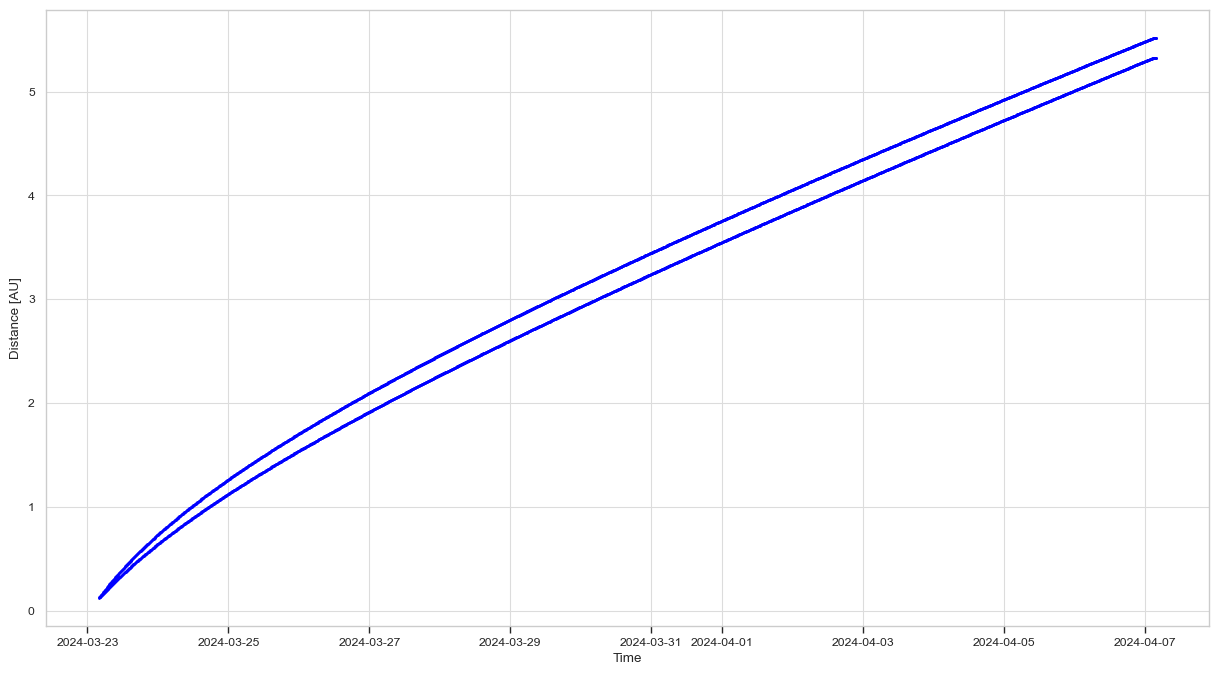

In [13]:
plt.figure(1, figsize=(15,8))
plt.plot(mdates.num2date(hc_time_num1), hc_r1[0], 'bo', ms=1)
plt.xlabel('Time')
plt.ylabel('Distance [AU]')

### DATA READING (Solar Orbiter and maybe for comparison - later - also Wind)

In [14]:
sc_input = pickle.load(open('../sub-L1/df_scaled_240323.pkl', 'rb'))
#[sc_input, header] = pickle.load(open('solo_rtn_2024-03-23.p', 'rb'))

print(sc_input.time)

l1 = pickle.load(open('../sub-L1/l1_pos_2024.p', 'rb'))

0      2024-03-23 00:00:00
1      2024-03-23 00:01:00
2      2024-03-23 00:02:00
3      2024-03-23 00:03:00
4      2024-03-23 00:04:00
               ...        
1018   2024-03-23 16:58:00
1019   2024-03-23 16:59:00
1020   2024-03-23 17:00:00
1021   2024-03-23 17:01:00
1022   2024-03-23 17:02:00
Name: time, Length: 1023, dtype: datetime64[ns]


In [15]:
#define expected arrival time at L1 (from ELEvo)
print(hc_arr_time1[-1])
sc_icme_start_time = datetime(2024,3,24,16,49) #hc_arr_time1[-1]
#sc_mo_start_time = datetime(2024,3,24,20,44)

speed = np.ones(len(sc_input.time_shifted_exp))
density = np.ones(len(sc_input.time_shifted_exp))
speed[sc_input.time_shifted_exp<sc_icme_start_time] = 500.
speed[sc_input.time_shifted_exp>=sc_icme_start_time] = 900.
density[sc_input.time_shifted_exp<sc_icme_start_time] = 5.
density[sc_input.time_shifted_exp<sc_icme_start_time] = 20.


2024-03-24 16:49:00+00:00


In [16]:
#load Wind data

get_wind = False

if get_wind:
    [wind_input, wind_h] = pickle.load(open(data_path+'wind_1995_now_gse.p', 'rb'))
    scut=np.where(wind_input.time> parse_time('2023-04-01').datetime)[0][0]
    wind_input = wind_input[scut:-1]
    print(wind_h, len(wind_input))

    wind_input = pred.convert_GSE_to_GSM_new(wind_input)
    
    pickle.dump(wind_input, open('data/wind_gsm.p', 'wb'))
    
#wind_input = pickle.load(open('data/wind_gsm.p', 'rb'))

In [17]:
# make SatData oject for Dst-calculation

sc_0 = SatData({'time': date2num(sc_input.time_shifted_exp),
               'btot': np.array(sc_input.bt_scaled), 'btot_err': abs(sc_input.bt_scaled_ub-sc_input.bt_scaled_lb), 'bx': np.array(sc_input.bx_scaled), 
               'bx_err': abs(sc_input.bx_scaled_ub-sc_input.bx_scaled_lb),'by': np.array(sc_input.by_scaled), 'by_err': abs(sc_input.by_scaled_ub-sc_input.by_scaled_lb), 
               'bz': np.array(sc_input.bz_scaled), 'bz_err': abs(sc_input.bz_scaled_ub-sc_input.bz_scaled_lb),
               'speed': speed, 'density': density}, source='Solar Orbiter')


#sc_0 = SatData({'time': date2num(sc_input.time),
 #               'btot': np.array(sc_input.bt), 'btot_err': abs(sc_input.bt_scaled_ub-sc_input.bt_scaled_lb), 'bx': np.array(sc_input.bx_scaled), 
  #             'bx_err': abs(sc_input.bx_scaled_ub-sc_input.bx_scaled_lb),'by': np.array(sc_input.by_scaled), 'by_err': abs(sc_input.by_scaled_ub-sc_input.by_scaled_lb), 
   #            'bz': np.array(sc_input.bz_scaled), 'bz_err': abs(sc_input.bz_scaled_ub-sc_input.bz_scaled_lb),
    #           'speed': np.ones(len(sc_input.time))*400., 'density': np.ones(len(sc_input.time))*5}, source='STEREO-A')

Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#
print(sc_0)

Positions.h['Units'] = 'AU'
Positions.h['ReferenceFrame'] = 'HEEQ'
Positions.h['Observer'] = 'Sun'
sc_0.pos = Positions

#sc_0.interp_nans()

sc_0.h['DataSource'] = "Solar Orbiter"
sc_0.h['SamplingRate'] = mdates.num2date(sc_0['time'][1]) - mdates.num2date(sc_0['time'][0])
sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_0_dst = sc_0.make_hourly_data()
print(sc_0_dst)

Length of data:		1023
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot', 'btot_err', 'bx_err', 'by_err', 'bz_err']
First data point:	2024-03-24 02:30:00+00:00
Last data point:	2024-03-25 02:57:51.872316+00:00

Header information:
                   DataSource:	
                    SourceURL:	
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10

Variable statistics:
         VAR        MEAN         STD
       speed      577.03      157.73
     density       16.34        7.49
          bx        2.75        6.39
          by        0.60        7.45
          bz        0.74        5.37
        btot        9.39        6.75
    btot_err        7.36        5.36
      bx_err        4.79        2.65
      by_err        3.65        4.63
      bz_err        3.01        3.03

Length of data:		24
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot', 'btot_err', 'bx

In [20]:
n_ensembles = 100000
time_shift_error = 1./24.

start_time_calculation = time.time()

dst1_input = np.abs(np.random.normal(10, 2, n_ensembles))
dst2_input = np.abs(np.random.normal(6, 1, n_ensembles))
dst3_input = np.abs(np.random.normal(10, 2, n_ensembles))

btot_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['btot'], sc_0['btot_err'])]) 
btot_array = np.transpose(btot_array)

bx_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['bx'], sc_0['bx_err'])]) 
bx_array = np.transpose(bx_array)

by_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['by'], sc_0['by_err'])]) 
by_array = np.transpose(by_array)

bz_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['bz'], sc_0['bz_err'])]) 
bz_array = np.transpose(bz_array)

speed_array = np.array([np.random.normal(k, 50., n_ensembles) for k in sc_0['speed']])
speed_array = np.transpose(speed_array)

density_array = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sc_0['density']]))
density_array = np.transpose(density_array)



btot_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['btot'], sc_0_dst['btot_err'])]) 
btot_array_hour = np.transpose(btot_array_hour)

bx_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['bx'], sc_0_dst['bx_err'])]) 
bx_array_hour = np.transpose(bx_array_hour)

by_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['by'], sc_0_dst['by_err'])]) 
by_array_hour = np.transpose(by_array_hour)

bz_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['bz'], sc_0_dst['bz_err'])]) 
bz_array_hour = np.transpose(bz_array_hour)

speed_array_hour = np.array([np.random.normal(k, 50., n_ensembles) for k in sc_0_dst['speed']])
speed_array_hour = np.transpose(speed_array_hour)

density_array_hour = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sc_0_dst['density']]))
density_array_hour = np.transpose(density_array_hour)

random_time_shift = np.random.normal(0, time_shift_error, n_ensembles)

sta_symh = []
sta_symh_err = []
sta_dst = []
sta_dst_err = []
wind_symh = []
wind_dst = []
    
for x in range(n_ensembles):
    

    #sta_symh_rand = pred.calc_dst_temerin_li(sc_0['time'], sc_0['btot'], sc_0['bx'], sc_0['by'], sc_0['bz'], sc_0['speed'], sc_0['speed'],sc_0['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=True)
    sta_symh_rand = pred.calc_dst_temerin_li(sc_0['time']+random_time_shift[x], btot_array[x], bx_array[x], by_array[x], bz_array[x], speed_array[x], speed_array[x], density_array[x], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=True)
    #sta_dst_rand = pred.calc_dst_temerin_li(sc_0_dst['time'], sc_0_dst['btot'], sc_0_dst['bx'], sc_0_dst['by'], sc_0_dst['bz'], sc_0_dst['speed'], sc_0_dst['speed'], sc_0_dst['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=False)
    sta_dst_rand = pred.calc_dst_temerin_li(sc_0_dst['time']+random_time_shift[x], btot_array_hour[x], bx_array_hour[x], by_array_hour[x], bz_array_hour[x], speed_array_hour[x], speed_array_hour[x], density_array_hour[x], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=False)
    #wind_symh_rand = pred.calc_dst_temerin_li(wind_0['time'], wind_0['btot'], wind_0['bx'], wind_0['by'], wind_0['bz'], wind_0['speed'], speedx, wind_0['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=True) #DSCOVR input (without speedx)
    #wind_dst_rand = pred.calc_dst_temerin_li(wind_0_hour['time'], wind_0_hour['btot'], wind_0_hour['bx'], wind_0_hour['by'], wind_0_hour['bz'], wind_0_hour['speed'], speedx_hour, wind_0_hour['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=False)
    
    
    sta_symh.append(sta_symh_rand)
    #sta_symh_err.append(sta_symh_rand_err)
    #wind_symh.append(wind_symh_rand)
    sta_dst.append(sta_dst_rand)
    #sta_dst_err.append(sta_dst_rand_err)
    #wind_dst.append(wind_dst_rand)

sc_0['dst']= np.mean(sta_symh, axis=0)
sc_0['dst_err_min']=np.mean(sta_symh,axis=0)-np.std(sta_symh, axis=0)
sc_0['dst_err_max']=np.mean(sta_symh,axis=0)+np.std(sta_symh, axis=0)
#wind_0['dst']= np.mean(wind_symh, axis=0)
#wind_0['dst_err']= np.std(wind_symh, axis=0)

sc_0_dst['dst']= np.mean(sta_dst, axis=0)
sc_0_dst['dst_err_min']= np.mean(sta_dst, axis=0)-np.std(sta_dst, axis=0)
sc_0_dst['dst_err_max']= np.mean(sta_dst, axis=0)+np.std(sta_dst, axis=0)
#wind_0_hour['dst']= np.mean(wind_dst, axis=0)
#wind_0_hour['dst_err']= np.std(wind_dst, axis=0)


end_time_calculation = time.time()

print('Time in seconds needed for calculation: ', round((end_time_calculation-start_time_calculation)/60,1), ' seconds')

Time in seconds needed for calculation:  3.3  seconds


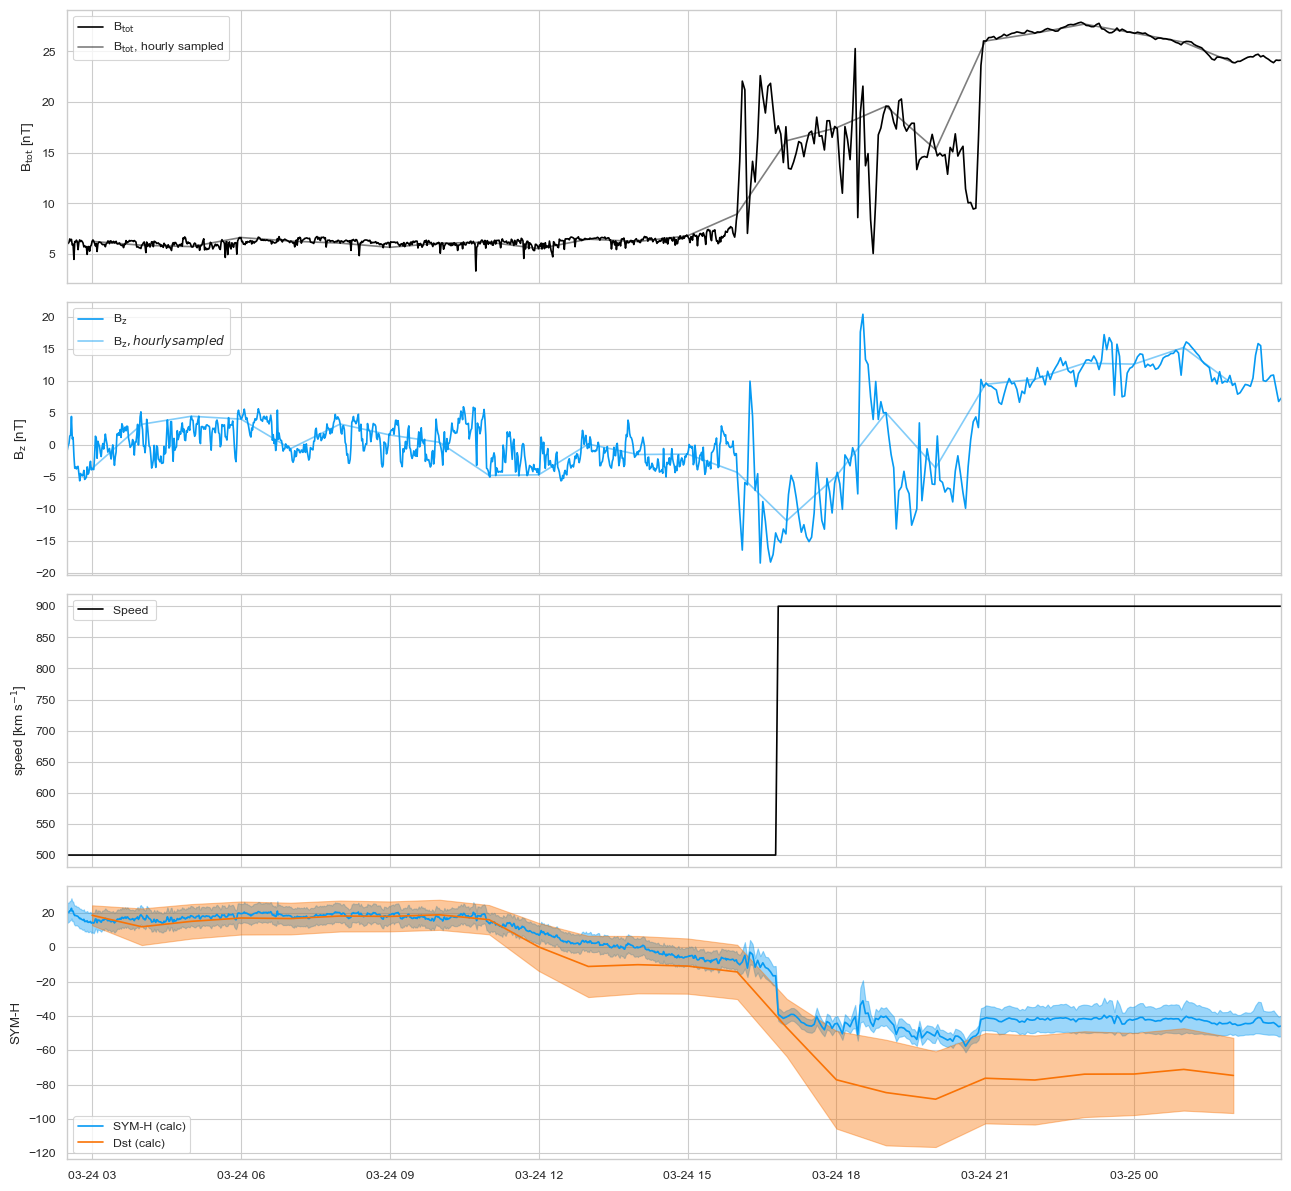

In [25]:
c0 = "xkcd:black"
c1 = "xkcd:magenta"
c2 = "xkcd:orange"
c3 = "xkcd:azure"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,12), sharex=True)

ax1.plot(mdates.num2date(sc_0['time']), sc_0['btot'], label=r'B$_{\mathrm{tot}}$', c=c0)
ax1.plot(mdates.num2date(sc_0_dst['time']), sc_0_dst['btot'], label=r'B$_{\mathrm{tot}}$, hourly sampled', c=c0, alpha=0.5)
ax1.set_ylabel(r'B$_{\mathrm{tot}}$ [nT]')
ax1.legend(loc='upper left')

ax2.plot(mdates.num2date(sc_0['time']), sc_0['bz'], label=r'B$_{\mathrm{z}}$', c=c3)
ax2.plot(mdates.num2date(sc_0_dst['time']), sc_0_dst['bz'], label=r'B$_{\mathrm{z}}, hourly sampled$', c=c3, alpha=0.5)
ax2.set_ylabel(r'B$_{\mathrm{z}}$ [nT]')
ax2.legend(loc='upper left')

ax3.plot(mdates.num2date(sc_0['time']), sc_0['speed'], label='Speed ', c=c0)
ax3.set_ylabel('speed [km s$^{-1}$]')
ax3.legend(loc='upper left')

ax4.plot(mdates.num2date(sc_0['time']), sc_0['dst'], label='SYM-H (calc)', c=c3)
ax4.plot(mdates.num2date(sc_0_dst['time']), sc_0_dst['dst'], label='Dst (calc)', c=c2)
ax4.fill_between(mdates.num2date(sc_0['time']), y1=sc_0['dst_err_min'], y2=sc_0['dst_err_max'], color=c3, alpha=0.4)
ax4.fill_between(mdates.num2date(sc_0_dst['time']), y1=sc_0_dst['dst_err_min'], y2=sc_0_dst['dst_err_max'], color=c2, alpha=0.4)
ax4.set_ylabel('SYM-H')
ax4.legend(loc='lower left')
plt.xlim(sc_0['time'][0],sc_0['time'][-1])
fig.tight_layout()

#plt.savefig('sub_l1_real_time_fin_20230323_new_correct.png')
#plt.close()
plt.show()

In [26]:
#pickle.dump([sc_0['dst'], sc_0['dst_err_min'], sc_0['dst_err_max']], open('symh_20230323_test.p', 'wb'))

# This part is for ELEvo-Movie only

In [10]:
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)

def plot_stereo_hi_fov(pos, time_num, timeind,ax,sc):    
    
    #plots the STA FOV HI1 HI2
    
    #STB never flipped the camera:    
    if sc=='B': 
        ang1d=-4
        ang2d=-24
        ang3d=-18
        ang4d=-88
        lcolor='blue'
    
    if sc=='A': 
        ang1d=4
        ang2d=24
        ang3d=18
        ang4d=88
        lcolor='red'

        #STA flipped during conjunction
        if mdates.date2num(datetime(2015,11,1))<time_num<mdates.date2num(datetime(2023,8,12)):  
            ang1d=-4
            ang2d=-24
            ang3d=-18
            ang4d=-88



    #calculate endpoints
    
    #sta position
    x0=pos.x[timeind]
    y0=pos.y[timeind]
    z0=0
    
    #sta position 180° rotated    
    x1=-pos.x[timeind]
    y1=-pos.y[timeind]
    z1=0
    
    #rotate by 4 deg for HI1 FOV
    ang=np.deg2rad(ang1d)
    rot=np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])    
    [x2,y2]=np.dot(rot,[x1,y1])
    z2=0    
    #add to sta position
    x2f=x0+x2
    y2f=y0+y2    
    z2f=0
    
    #rotate 2
    ang2=np.deg2rad(ang2d)
    rot2=np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]])    
    [x3,y3]=np.dot(rot2,[x1,y1])
    z3=0    
    #add to sta position
    x3f=x0+x3
    y3f=y0+y3    
    z3f=0
    
    #rotate 3
    ang3=np.deg2rad(ang3d)
    rot3=np.array([[np.cos(ang3), -np.sin(ang3)], [np.sin(ang3), np.cos(ang3)]])    
    [x4,y4]=np.dot(rot3,[x1,y1])
    z4=0    
    #add to sta position
    x4f=x0+x4
    y4f=y0+y4    
    z4f=0    

    #rotate 4
    ang4=np.deg2rad(ang4d)
    rot4=np.array([[np.cos(ang4), -np.sin(ang4)], [np.sin(ang4), np.cos(ang4)]])    
    [x5,y5]=np.dot(rot4,[x1,y1])
    z5=0    
    #add to sta position
    x5f=x0+x5
    y5f=y0+y5    
    z5f=0    

    
    #convert to polar coordinates and plot
    [r0,t0,lon0]=cart2sphere(x0,y0,z0)    
    #[r1,t1,lon1]=hd.cart2sphere(x1,y1,z1)    
    [r2,t2,lon2]=cart2sphere(x2f,y2f,z2f)    
    [r3,t3,lon3]=cart2sphere(x3f,y3f,z3f)    
    [r4,t4,lon4]=cart2sphere(x4f,y4f,z4f)    
    [r5,t5,lon5]=cart2sphere(x5f,y5f,z5f)    
    
    #ax.plot([lon0,lon1],[r0,r1],'--r',alpha=0.5)
    ax.plot([lon0,lon2],[r0,r2],linestyle='-',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon3],[r0,r3],linestyle='-',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon4],[r0,r4],linestyle='--',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon5],[r0,r5],linestyle='--',color=lcolor,alpha=0.3, lw=0.8)

In [11]:
def make_frame(k):
    '''
    loop each frame in multiprocessing
    '''
    
    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((4,2), (0, 0), rowspan=4, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)
    
    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))
            
            if p == 0:
                ax.plot(longcirc1[0],rcirc1[0], color='tab:blue', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
                ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:blue', alpha=.05)
            if p == 1:
                ax.plot(longcirc1[0],rcirc1[0], color='tab:orange', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
                ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:orange', alpha=.05)

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 
    
    
    if o_time_num[-1] > time_now+days_window:
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.where(o_time_num > time_now+days_window)[0][0]
        o=o1[oindex1:oindex2]
        if np.isnan(o.bt).all():
            o.bt=np.nan
    elif np.logical_and((o_time_num[-1] < time_now+days_window),(o_time_num[-1] > time_now-days_window)):
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.size(s1)-1
        o=o1[oindex1:oindex2]
    else: o=[] 

    #---------------- NOAA mag

    ax4 = plt.subplot2grid((4,2), (0, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.7, alpha=0.8)
    ax4.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:blue')
    ax4.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:orange')
    #ax4.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #ax4.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')

    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)
        
        #for i in range(len(hc_arr_time1)):
         #   if np.isnan(hc_arr_hit1[i]) == False:       
               # ax4.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
               # ax4.annotate(hc_arr_id1[i][0:16], (hc_arr_time1[i], np.nanmax(n.bt)+5), fontsize=10, rotation=90)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)
       
                




    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((4,2), (1, 1))
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)    
    #ax6.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:blue')
    #ax6.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:orange')
    #ax6.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #ax6.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #for i in range(len(hc_arr_time1)):
     #   ax6.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
        
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
            
            
            
    # ----------------- SolO mag        
    ax7 = plt.subplot2grid((4,2), (2, 1))
    ax7.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax7.plot_date([hc_arr_time1_solo[0],hc_arr_time1_solo[0]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:blue')
    ax7.plot_date([hc_arr_time1_solo[1],hc_arr_time1_solo[1]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:orange')
    #ax7.plot_date([hc_err_arr_time_min1_solo,hc_err_arr_time_min1_solo], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:orange')
    #ax7.plot_date([hc_err_arr_time_max1_solo,hc_err_arr_time_max1_solo], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:orange')
    #for i in range(len(hc_arr_time1_solo)):
     #   ax7.axvspan(hc_err_arr_time_min1_solo[i], hc_err_arr_time_max1_solo[i], alpha=0.04, color='tab:orange')
        
    ax7.set_xlim(time_now-days_window,time_now+days_window)
    ax7.set_xticklabels([])
    ax7.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(o)>0:
        
        plt.plot_date(o.time,o.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(o.time,o.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(o.time,o.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(o.time,o.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-o.bt)):         
            ax7.set_ylim(np.nanmin(-o.bt)-5, np.nanmax(o.bt)+10)
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((4,2), (3, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [-100,1000],'-k', lw=0.5, alpha=0.8)
    ax5.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:blue')
    ax5.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-k', lw=1, alpha=0.8, color='tab:orange')
    #ax5.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #ax5.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #for i in range(len(hc_arr_time1)):
     #   ax5.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 900))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    #ax5.set_xticklabels([])
    
    if np.size(s)>0:
        plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-g',label='V',linewidth=0.7)  
        
    #if np.isfinite(np.nanmin(n.bt)):    
    #ax5.set_ylim(np.nanmin(-n.bt)-50, np.nanmax(n.bt)+50)


    plt.figtext(0.95,0.77,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.58,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.40,'SolarOrbiter', color='coral', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.92,0.91,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.91,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.91,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.91,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UTC', ha='center',color=backcolor,fontsize=fsize+6)
    
    #plt.figtext(0.02, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.02, 0.1,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.02,0.01/2,r'Austrian Space Weather Office, GeoSphere Austria', fontsize=fsize-4, ha='left',color=backcolor) 
    plt.figtext(0.99,0.01/2,'helioforecast.space', fontsize=fsize-4, ha='right',color=backcolor) 
    
    #logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    #newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    #newax.imshow(logo)
    #newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)



    #save figure
    framestr = '%05i' % (k)
    filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')


    plt.close('all')


In [47]:
def make_frame2(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((4,2), (0, 0), rowspan=4, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)
    print(cmeind1)
    
    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))
            
            if p == 0:
                ax.plot(longcirc1[0],rcirc1[0], color='tab:blue', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
                ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:blue', alpha=.05)
            if p == 1:
                ax.plot(longcirc1[0],rcirc1[0], color='tab:orange', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
                ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:orange', alpha=.05)

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 
    
    
    if o_time_num[-1] > time_now+days_window:
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.where(o_time_num > time_now+days_window)[0][0]
        o=o1[oindex1:oindex2]
        if np.isnan(o.bt).all():
            o.bt=np.nan
    elif np.logical_and((o_time_num[-1] < time_now+days_window),(o_time_num[-1] > time_now-days_window)):
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.size(s1)-1
        o=o1[oindex1:oindex2]
    else: o=[] 

    #---------------- NOAA mag
    
    days_dist = 1
    
    ax4 = plt.subplot2grid((3,2), (1, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.7, alpha=0.8)
    ax4.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-k', lw=.9, color='tab:blue')
    ax4.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-k', lw=.9, color='tab:orange')
    ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax4.tick_params(which='both', bottom=False)
    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)
        
        #for i in range(len(hc_arr_time1)):
         #   if np.isnan(hc_arr_hit1[i]) == False:       
               # ax4.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
               # ax4.annotate(hc_arr_id1[i][0:16], (hc_arr_time1[i], np.nanmax(n.bt)+5), fontsize=10, rotation=90)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)
       
                


    #----------------  STEREO-A mag
    
    #ax6 = plt.subplot2grid((4,2), (1, 1))
    #ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    #ax6.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-', lw=1, alpha=0.8, color='tab:orange')
    #ax6.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-', lw=1, alpha=0.8, color='tab:blue')
    #for i in range(len(hc_arr_time1)):
     #   ax6.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
        
    #ax6.set_xlim(time_now-days_window,time_now+days_window)
    #ax6.set_xticklabels([])
    #ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    #plt.yticks(fontsize=fsize-1) 
    #plt.tick_params( axis='x', labelbottom='off')
    
    #if np.size(s)>0:
        
    #    plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
    #    plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
    #    plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
    #    plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
    #    if np.isfinite(np.nanmin(-s.bt)):         
    #        ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
            
            
            
    # ----------------- SolO mag        
    ax7 = plt.subplot2grid((3,2), (2, 1))
    ax7.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax7.plot_date([hc_arr_time1_solo[0],hc_arr_time1_solo[0]], [-1000,1000],'-k', lw=.9, color='tab:blue')
    ax7.plot_date([hc_arr_time1_solo[1],hc_arr_time1_solo[1]], [-1000,1000],'-k', lw=.9, color='tab:orange')
    ax7.set_xlim(time_now-days_window,time_now+days_window)
    ax7.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax7.tick_params(which='both', bottom=False)
    ax7.set_xticklabels([])
    ax7.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(o)>0:
        
        plt.plot_date(o.time,o.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(o.time,o.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(o.time,o.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(o.time,o.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-o.bt)):         
            ax7.set_ylim(np.nanmin(-o.bt)-5, np.nanmax(o.bt)+10)
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((3,2), (0, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [-100,1000],'-k', lw=0.5, alpha=0.8)
    ax5.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [-1000,1000],'-k', lw=.9, color='tab:blue')
    ax5.plot_date([hc_arr_time1[1],hc_arr_time1[1]], [-1000,1000],'-k', lw=.9, color='tab:orange')
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 900))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax5.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax5.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(days_dist/12))
    ax5.tick_params(axis='x', labelsize=15)
    #ax5.set_xticklabels([])
    
    #if np.size(s)>0:
     #   plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-k',label='V',linewidth=0.7)  
        
    #if np.isfinite(np.nanmin(n.bt)):    
    #ax5.set_ylim(np.nanmin(-n.bt)-50, np.nanmax(n.bt)+50)


    plt.figtext(0.95,0.77,'DSCOVR', color='mediumseagreen', ha='center',fontsize=fsize+3)
    #plt.figtext(0.95,0.58,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'Solar Orbiter', color='coral', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'DSCOVR', color='mediumseagreen', ha='center',fontsize=fsize+3)
    #plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    
    plt.figtext(0.92,0.91,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.91,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.91,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.91,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UTC', ha='center',color=backcolor,fontsize=fsize+6)
    
    #plt.figtext(0.02, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.02, 0.1,'CME - initial parameters from DONKI (CCMC)', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.08,'CME - updated initial parameters', fontsize=fsize-1, ha='left',color='tab:orange')
    
    plt.figtext(0.02, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    #plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    #plt.figtext(0.02,0.01/2,r'Austrian Space Weather Office, GeoSphere Austria', fontsize=fsize-4, ha='left',color=backcolor) 
    #plt.figtext(0.99,0.01/2,'helioforecast.space', fontsize=fsize-4, ha='right',color=backcolor) 
    
    #logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    #newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    #newax.imshow(logo)
    #newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)

   
    #save figure
    #framestr = '%05i' % (k)  
    filename=outputdirectory+'/real_time_march2024.pdf'
    #plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #if k==0: print(filename)

    #plt.close('all')
    plt.show()

    ########################################### loop end


In [55]:
get_data=1
if get_data > 0:

    ########## NOAA
    print('load NOAA data GSM')
    #file='noaa_rtsw_last_35files_now.p'
    #file='dscovr_gsm_2024-03-20-09.p'
    file='../sub-L1/noaa_rtsw_last_300files_now.p'
    [n,nh]=pickle.load(open(file, "rb" ) ) 
    
    n1=n
    
    ########### STA GSM
    print('load STEREO-A data GSM')
    #filesta1='stereoa_beacon_gsm_last_35days_now.p'
    filesta1='../sub-L1/stereoa_beacon_gsm_last_400days_now.p'
    [s,hs]=pickle.load(open(filesta1, "rb" ) )  

    #cut with 2021 January 1st
    #scut=np.where(s.time> parse_time('2020-01-01').datetime)[0][0]

    s1=s
    
    ########## SolO
    print('load SolO data RTN')
    filesolo='../sub-L1/solo_2020_now_rtn.p'
    #[solo1,hsolo]=pickle.load(open(filesolo, "rb" ) ) 
    [solo1,hsolo] = pickle.load(open('../sub-L1/solo_rtn_2024-03-23_gsm.p', 'rb'))
    
    #solo1_gse = pred.convert_RTN_to_GSE_sta_l1(solo1)
    #solo1_gsm = pred.convert_GSE_to_GSM_new(solo1_gse)
    
    #pickle.dump([solo1_gsm, hsolo], open('../sub-L1/solo_rtn_2024-03-23_gsm.p', 'wb'))
    
    o1=solo1
    
    n_time_num=parse_time(n1.time).plot_date
    s_time_num=parse_time(s1.time).plot_date
    o_time_num=parse_time(o1.time).plot_date

    
    
print('done')

load NOAA data GSM
load STEREO-A data GSM
load SolO data RTN
done


In [51]:
plt.close('all')

print('Define settings')

#Coordinate System
#frame='HCI'
frame='HEEQ'
#print(frame)

today = datetime.now()

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

AUkm=149597870.7   

#black background on or off
black=True
#black=False

#animation settings
plot_orbit=True
#plot_orbit=False
#plot_parker=True
plot_parker=False

high_res_mode=False

format_str = '%Y-%m-%d'  
format_str_minutes = '%Y-%m-%d %H:%M'
date_today_hour = datetime.now().strftime(format_str)

outputdirectory='output/frames'#+str(date_today_hour)
animdirectory='output/'
t_start = mdates.num2date(data_donki.time21_5[index]).replace(microsecond=0, second=0, minute=0)#.strftime(format_str_minutes)
t_end  = mdates.num2date(data_donki.time21_5[index]).replace(microsecond=0, second=0, minute=0)+timedelta(days=3)
print(t_start)
#res_in_days=1/72. #every 20min
res_in_days=1/144. #every 10min
#res_in_days=1/1440. # every minute
#res_in_days=1/24. #every hour

#make time range to see how much frames are needed 
starttime = parse_time(t_start)
endtime = parse_time(t_end)
alltimes = []
while starttime < endtime:
    alltimes.append(starttime)
    starttime += timedelta(days=res_in_days)
k_all=np.size(alltimes)

print('# of frames: ', k_all)

#print(date_today_hour)
days_window=1.6    #size of in situ timerange

if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)

print('done')

#positions_plot_directory='results/plots_positions/'
#if os.path.isdir(positions_plot_directory) == False: os.mkdir(positions_plot_directory)

#print(k_all)

#print('done')


Define settings
2024-03-23 03:00:00+00:00
# of frames:  433
done


Save kinematics plots and overview plot for current time
(array([ 205, 2365]),)


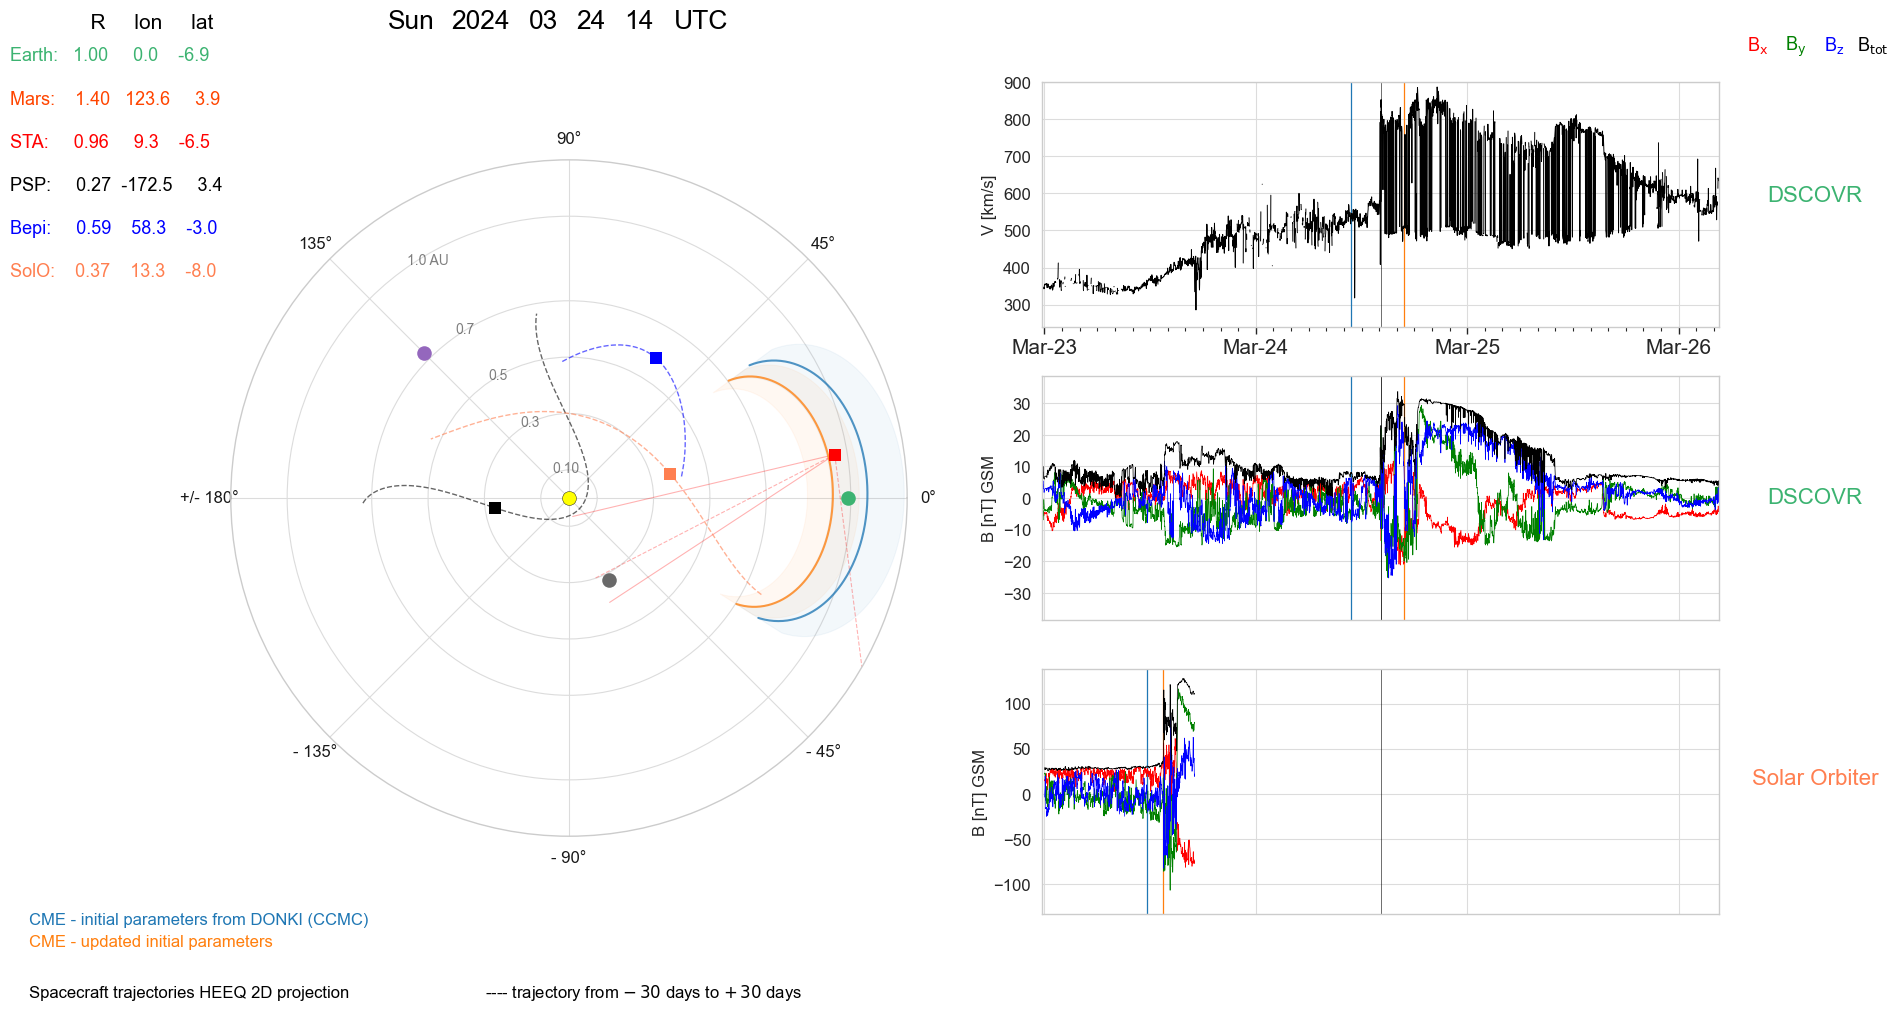

done


In [56]:
#for server
#matplotlib.use('Qt5Agg')

print('Save kinematics plots and overview plot for current time')

#%matplotlib inline

start_time=time.time()

#print()
#print('make animation')

#animation start time in matplotlib format

frame_time_num=parse_time(t_start).plot_date

frame_time_num_list = [frame_time_num+k*res_in_days for k in range(k_all)]

#k_today = np.where(frame_time_num_list==mdates.date2num(datetime.now().replace(microsecond=0, second=0, minute=0)))

frame_index = np.where(frame_time_num_list==mdates.date2num(datetime(2024,3,24,14,10)))[0][0]

#sns.set_context('talk')
#if not black: sns.set_style('darkgrid'),#{'grid.linestyle': ':', 'grid.color': '.35'}) 
#if black: sns.set_style('white',{'grid.linestyle': ':', 'grid.color': '.35'})   

# animation settings 

fsize=13
fadeind = 200*24 #if s/c positions are given in hourly resolution
#fadeind=int(20/res_in_days)#
#fadeind=int(120/res_in_days)

symsize_planet=110
symsize_spacecraft=80

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

######################## make frames

#for debugging
#don't close plot in make_frame when testing

#plot_kinematics(hc_time_num1, hc_r1, hc_v1)
####################### plot and save frame with todays date and hour 
#make_frame3(k_today[0][0]) 

####################### test animation frames (different frame numbers)
make_frame2(frame_index)#k_today[0][0])

#for i in np.arange(1,3,1):
#    make_frame(i)

print('done') 


In [27]:
make_movie = False

if make_movie:
    
    import multiprocessing
    import multiprocess as mp
    matplotlib.use('Agg')

    print('Creating ', k_all,' frames')

    print()

    start_time=time.time()

    #number of processes depends on your machines memory; check with command line "top"
    #how much memory is used by all your processesii
    nr_of_processes_used=4
    print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
          'with nr of processes used: ',nr_of_processes_used)

    #run multiprocessing pool to make all movie frames, depending only on frame number

    pool=mp.get_context('fork').Pool(processes=used)

    #pool = mp.Pool(processes=nr_of_processes_used)
    #input=[i for i in range(k_all)]
    input=[i for i in np.arange(1,k_all,1)]
    pool.map(make_frame, input)
    pool.close()
    pool.join()
    #for i in input:
     #   make_frame2(i)

    print('time in min: ',np.round((time.time()-start_time)/60))
    print('plots done, frames saved')


In [ ]:
ffmpeg_path=''

os.system(ffmpeg_path+'ffmpeg -r 30 -i output/frames/pos_anim_%05d.jpg -b 5000k \
    -r 30 output/elevo_real_time_march_2024.mp4 -y -loglevel warning') 

print('movie done & saved')

Please use -b:a or -b:v, -b is ambiguous


movie done & saved
